In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from multiprocessing import Pool
import inspect
import pickle

from evolver import Evolver
from models import Model3, Model1_2, Model2
from util_funs import find_initial_params, plot_chains, print_latex_result, read_files,\
    filter_data, filter_file_names, get_run_id, emcee_analysis

np.random.seed(12345)

%load_ext autoreload
%autoreload 2

# True if you want to read from the dataset files, False if you want to generate the date with the model
USE_DATASET = False

Best time range is [0, 2]


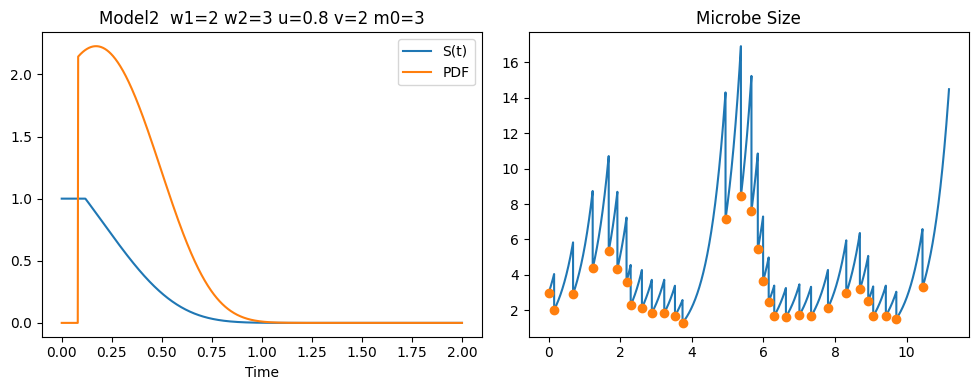

In [2]:
if not USE_DATASET:
    m0, w1, w2, u, v = 3, 2, 3, 0.8, 2
    model = Model2(m0=m0, w1=w1, w2=w2, u=u, v=v)



    # Here we define our model
    # a, b, c, d, w2, u, v = 4, 0.3, 3, 10, 0.8, 2, 3
    # m_f_i = 5
    # model = Model3(a=a, b=b, c=c, d=d, m_f=m_f_i, w2=w2, u=u, v=v)

    # Plot the model
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    model.get_figure(axs[0])


    # Here we make the model evolve (and divide)
    n_generations = 400
    evolver = Evolver(model=model)
    evolver.evolve(n_generations, debug=False)

    # Here we show some of the result
    end_gen = 30
    time, data = evolver.get_data(0, end_gen)
    final_time, final_data = evolver.get_start_data(0, end_gen)

    ptime = evolver.time[evolver.offset_start[0] : evolver.offset_end[end_gen] + 1]
    params = evolver.params[evolver.offset_start[0] : evolver.offset_end[end_gen] + 1]

    axs[1].plot(time, data[:, 0])
    axs[1].set_title('Microbe Size')
    axs[1].plot(final_time, final_data[:, 0], marker = 'o', linestyle = '');

100%|██████████| 1000/1000 [00:16<00:00, 61.39it/s]


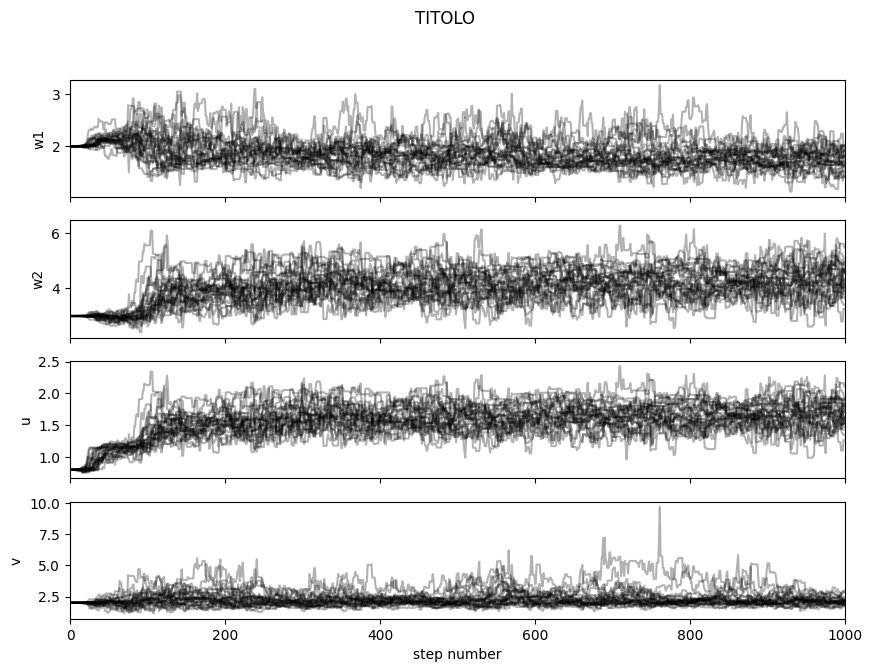

The chain is too short to get the auto correlation time
Flat samples shape:  (350, 4)


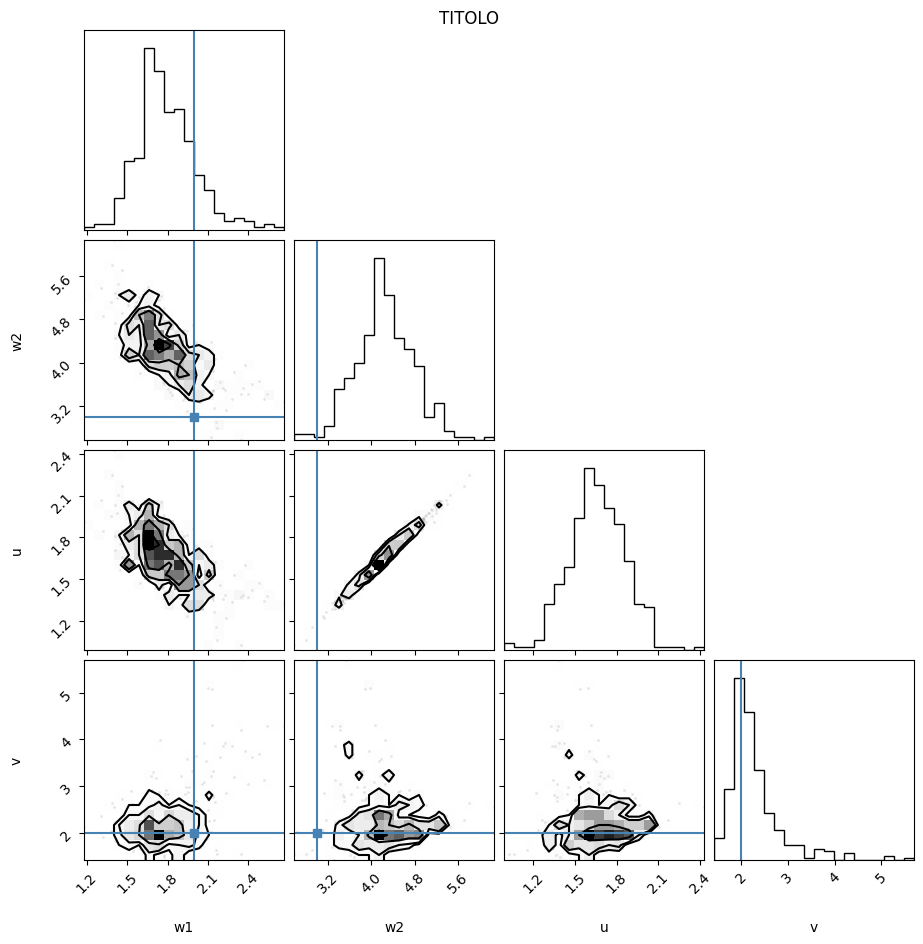

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
# Here we use the data generated from our model to estimate the parameters 

if not USE_DATASET:
    truth = evolver.model.fix_params.copy() # our parameters defined above
    labels =  evolver.model.fix_params_label.copy()

    nwalkers = 25 # number of walkers for the MCMC
    # We add some gaussian noise to our initial parameters
    guess = np.array(truth) + 1e-4 * np.random.randn(nwalkers, len(truth)) 

    spans = evolver.spans
    params_list = []
    for i in range(evolver.params.shape[1]): # the order is defined in the __init__ method of the model
        params_list.append(evolver.params[:, i][:-1])


    chain_lenght = 1000
    discard = 500
    thin_number = 35
    title="TITOLO"
    emcee_analysis(nwalkers=nwalkers, truths=truth, log_prob_fn=evolver.model.log_prob, args=(spans, *params_list),
                   guess = guess, chain_lenght=chain_lenght, labels=labels, use_pool=True, discard=discard,
                   thinning=thin_number, plot=True, title=title)


In [ ]:
################### TO READ AND WRITE THE DATASET ###################
tanouchi25c_set = pd.read_csv("./dataset/Tanouchi25C.csv")
tanouchi37c_set = pd.read_csv("./dataset/Tanouchi37C.csv")
susman18_set = pd.read_csv("./dataset/Susman18_physical_units.csv")
tanouchi25c_set.df_name = "tanouchi25c"
tanouchi37c_set.df_name = "tanouchi37c"
susman18_set.df_name = "susman18"

names_to_dataset_map = {d.df_name: d for d in [tanouchi25c_set, tanouchi37c_set, susman18_set]}

df = tanouchi37c_set
WRITE_ON_FILE = True
OUTPUT = False
AUTO_FIND_P0 = True
FOLDER_PATH = "./results/"
DF_NAME = df.df_name
lineages = []
nwalkers = 25
chain_lenght = 3000
discard = 1000
thin_number = 35
model = Model2()
run_id = get_run_id(model.__class__)


params_mapping = {Model3: (['length_birth'],
                           [slice(0, None)])}

START = False
if USE_DATASET and START:

    columns = ["growth_rate"]
    df, df_deleted = filter_data(df, filter_cols=columns, show=False, remove_lineages=True)
    print(f"Eliminated {len(df_deleted)} rows")

    if model.__class__ == Model3:
        a = 104.197
        b = 0.007
        c = 53.654
        d = 64.138
        w2 = 1.832
        u = 0.928
        v = 2.461

        if AUTO_FIND_P0:
            truths = find_initial_params(df)
        else:
            truths = [a, b, c, d, w2, u, v]
    else:
        raise ValueError("Specify the truth for this model")

    labels = model.fix_params_label

    ndim = len(truths)
    guess = np.array(truths) + 1e-4 * np.random.randn(nwalkers, ndim)

    if not lineages:
        lineages = list(df['lineage_ID'].unique().astype(int))

    df = df[df["lineage_ID"].isin(lineages)]

    with open(FOLDER_PATH + f"run_{run_id}.txt", "w") as f:
        f.write(inspect.getsource(model.log_prior))

    print(f"######## ANALYZING DATASET {DF_NAME}, RUN_ID: {run_id} ########")
    print("Initial Parameters:")
    print(" ".join([f"{l}={v:.3f}" for v, l in zip(truths, labels)]))
    print("")

    for (lin_id,), df_lin in df.groupby(["lineage_ID"]):
        print(f"DATASET {DF_NAME}, LINEAGE: {lin_id}, n data: {len(df_lin)}")

        spans = df_lin["generationtime"][1:].to_numpy()
        params_list = []
        for param, slic in zip(*params_mapping[model.__class__]):
            params_list.append(df_lin[param][slic].to_numpy())

        title = f"{DF_NAME}  run_id: {run_id}  lineage: {lin_id}"
        result = emcee_analysis(nwalkers=nwalkers, truths=truths, log_prob_fn=model.log_prob,
                                args=(spans, *params_list), guess=guess, chain_lenght=chain_lenght,
                                labels=labels, use_pool=True, discard=discard, thinning=thin_number,
                                plot=OUTPUT)
        samples, flat_samples, result_dict = result

        if WRITE_ON_FILE:
            data = {"n_walkers": nwalkers, "ndim": ndim, "dataset": DF_NAME, "lineage_id": lin_id,
                    "truths": truths, "initial_guess": guess, "labels": labels,
                    # "spans": spans, "alphas": alphas, "kappas": kappas, "m_finals": m_finals,
                    "samples": samples, "tau": None, "thin_number": thin_number, "discard": discard,
                    "flat_samples": flat_samples, "result_dict": result_dict, "data_length": len(df_lin),
                    "data": [spans, *params_list],
                    "run_id": run_id
                    }

            filename = f"{DF_NAME}_run_{run_id:06}_lin_{int(lin_id):03}.bin"
            Path(FOLDER_PATH).mkdir(parents=True, exist_ok=True)

            with open(FOLDER_PATH + filename, "wb") as f:
                pickle.dump(data, f)

            print("File created: ", FOLDER_PATH + filename)
            print("----------------------------------------------------------")


In [ ]:
########### READ BACK THE FILE CREATED ########################
FOLDER_PATH = "./results/"
RUN_ID = "682517"

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# lineages = [1, 2]
# dataset_results_dict = read_files(FOLDER_PATH, df_name="tanouchi25c", run_id=RUN_ID, lineages=lineages)

# for _, data in dataset_results_dict.items():
#     df_name, lin_id = data["dataset"], data["lineage_id"]
#     labels, samples, flat_samples = data["labels"], data["samples"], data["flat_samples"]
#     result_dict, truths = data["result_dict"], data["truths"]

#     title = f"DATASET {df_name}, lineage {lin_id}"

#     print(title)
#     plot_chains(samples, title=title, labels=labels)
#     fig = corner.corner(flat_samples, labels=labels, truths=truths)
#     fig.suptitle(title)
#     plt.show()
#     print_latex_result(list(result_dict.values()), labels)
#     print("-------------------------------")
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


lineages = []
dataset_results_dict = read_files(FOLDER_PATH, df_name="tan", run_id=RUN_ID,lineages=lineages)

ROWS, COLS = 3, 3
fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4))

for i, data in enumerate(dataset_results_dict.values()):
    df_name, lin_id = data["dataset"], data["lineage_id"]
    labels, flat_samples = data["labels"], data["flat_samples"]
    result_dict, truths = data["result_dict"], data["truths"]

    # recall parameter order = a, b, c, d, w2, u, v

    # for j in range(flat_samples.shape[1]):
    #     nbins = int(np.sqrt(flat_samples[:, j].shape[0]))
    #     index = (j // COLS, j % COLS)
    #     if (index == (0,2) or index == (1,0)): continue
    #     axs[index].hist(flat_samples[:, j], alpha=0.7, bins=nbins, label=f"Lin {lin_id}", density=True)

    nbins = int(np.sqrt(flat_samples.shape[0]))

    axs[0, 0].hist(flat_samples[:, 0], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    axs[0, 1].hist(flat_samples[:, 1], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    w1 = flat_samples[:, 0] * flat_samples[:, 1]
    axs[0, 2].hist(w1, label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    sigma_w1 = np.sqrt(flat_samples[:, 0]) * flat_samples[:, 1]
    axs[1, 0].hist(sigma_w1, label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)

    axs[1, 1].hist(flat_samples[:, 4], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    axs[1, 2].hist(flat_samples[:, 4] / w1, label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    axs[2, 0].hist(flat_samples[:, 5], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    axs[2, 1].hist(flat_samples[:, 6], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    axs[2, 2].hist(flat_samples[:, 5] / flat_samples[:, 6], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    

for j, label in enumerate(labels):
    nbins = int(np.sqrt(flat_samples[:, j].shape[0]))
    index = (j // COLS, j % COLS)
    axs[index].set_title(label)

fig.suptitle(f"DATASET {df_name}, #data: {len(dataset_results_dict)}")
axs[0, 0].set_title('a')
axs[0, 1].set_title('b')
axs[0, 2].set_title('w1 = a * b')
axs[1, 0].set_title('sigma_w1 = sqrt(a) * b')
axs[1, 1].set_title('w2')
axs[1, 2].set_title('w2 / w1')
axs[2, 0].set_title('u')
axs[2, 1].set_title('v')
axs[2, 2].set_title('u / v');

axs[1, 0].set_title("w2 / w1")
axs[2, 1].set_title("u / v");
axs[2, 2].set_title("w1 = a * b");




# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# ROWS, COLS = 2, 2

# for i, (_, data) in enumerate(dataset_results_dict.items()):
#     df_name, lin_id = data["dataset"], data["lineage_id"]
#     if int(lin_id) not in [1, 2, 3] or not df_name.startswith("tan"):
#         continue

#     print("Compatible file: ", df_name, " lineage: ", lin_id)
#     labels, flat_samples = data["labels"], data["flat_samples"]
#     results, truths = data["result_dict"], data["truths"]
#     data_length = data["data_length"]
#     # spans = data["data"]["spans"]
#     # alphas = data["data"]["alphas"]
#     # kappas = data["data"]["kappas"]
#     # m_finals = data["data"]["m_finals"]

#     params = {"a":results["a"][0], "b":results["b"][0], "c":results["c"][0], "d":results["d"][0],
#               "m_f":1, "w2":results["w2"][0], "u":results["u"][0], "v":results["v"][0]}
#     model_test = Model3(**params)
#     params_txt = model_test.get_params_str()

#     evolver_test = Evolver(model_test)
#     evolver_test.evolve(n_div=data_length)

#     fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4))

#     model_data = [evolver_test.spans]
#     for i in range(evolver_test.params.shape[1]): # the order is defined in the __init__ method of the model
#         model_data.append(evolver_test.params[:, i])
    
#     params_labels = ["Lifetime"] + model_test.var_params_label
#     for j, value in enumerate(data["data"]):
#         nbins = int(np.sqrt(len(model_data[j])))

#         index = (j // COLS, j % COLS)
#         axs[index].hist(model_data[j], label="Generated", density=True, alpha=0.7, bins=nbins)
#         axs[index].hist(value, label="Lineage", density=True, alpha=0.7, bins=nbins)
#         axs[index].set_title(params_labels[j])
#         axs[index].legend()
    
#     fig.suptitle(f"{DF_NAME} lineage: {lin_id}, params: {params_txt}", wrap=True)


In [ ]:
# df = tanouchi25c_set
# df = tanouchi37c_set
# df = susman18_set
df = susman18_set
run_id = "937761"


acmin = 1
acmax = 20 + 1
lineages = [*np.arange(10, 19)]
fig, axs = plt.subplots(2, 1, figsize=(18, 14))
# plt.acorr
plt.suptitle(f"{df.df_name}, runid: {run_id}")
axs[0].hlines([0], acmin, acmax - 1, colors="black", lw=1)
axs[1].hlines([0], acmin, acmax - 1, colors="black", lw=1)
axs[0].set_title("Alphas Autocorrelations")
axs[1].set_title("Kappas Autocorrelations")

lineages_passed = [lin for _, _, lin in filter_file_names(FOLDER_PATH, df.df_name, run_id).values()]

sums = np.zeros(shape=(2, acmax - acmin))
n_data = 0
include_exc = False
for (lin_id,), df_lin in df.groupby(["lineage_ID"]):
    if lineages and lin_id not in lineages:
        continue

    ac_alpha_list = []
    ac_kappa_list = []
    for i in range(acmin, acmax):
        a = df_lin["growth_rate"][:-i]
        b = df_lin["growth_rate"][i:]
        ac_alpha_list.append(np.corrcoef(a, b)[0, 1])

        c = df_lin["division_ratio"][1:][:-i]
        d = df_lin["division_ratio"][1:][i:]
        ac_kappa_list.append(np.corrcoef(c, d)[0, 1])

    passed = int(lin_id) in lineages_passed
    if include_exc or passed:
        sums[0, :] += ac_alpha_list
        sums[1, :] += ac_kappa_list
        n_data += 1

    x_range = np.arange(acmin, acmax)
    ls = "solid" if passed else "dashed"
    axs[0].plot(x_range, ac_alpha_list, label=f"Lin {lin_id}", ls=ls, lw=1)
    axs[1].plot(x_range, ac_kappa_list, label=f"Lin {lin_id}", ls=ls, lw=1)
    # plt.scatter(x_range, autocorre_list, s=10)

sums = sums/n_data
text_mean = "With excluded" if include_exc else "Without excluded"
axs[0].plot(x_range, sums[0, :], ls="dotted", color="black", lw=2, label=f"Mean ({text_mean})")
axs[1].plot(x_range, sums[1, :], ls="dotted", color="black", lw=2, label=f"Mean ({text_mean})")
axs[0].legend()
axs[1].legend();


In [ ]:
# tan37_exp_df = pd.read_csv('./exports/tanouchi37c_export_run_628735.csv')
# tan37_exp_df = tan37_exp_df.sort_values(by = 'lineage_id')
# tan37_exp_df